# Zoom vs Teams energy analysis

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Supress warnings
import warnings
warnings.filterwarnings('ignore')


def get_pcm(tool, variation):
    df = pd.DataFrame()
    run_counter = 0
    for root, dirs, files in os.walk(f'./{tool}_{variation}'):
        for file in files:
            if file == 'pcm.log':
                tmp = pd.read_csv(os.path.join(root, file), header=[1])
                
                tmp['Time'] = pd.to_datetime(tmp['Time'], format='%H:%M:%S.%f')
                tmp['Time'] = tmp['Time'].dt.hour * 3600 + tmp['Time'].dt.minute * 60 + tmp['Time'].dt.second + tmp['Time'].dt.microsecond / 1e6
                tmp['Time'] = tmp['Time'] - tmp['Time'].min()

                tmp['tool'] = tool
                tmp['variation'] = variation
                tmp['run'] = run_counter
                run_counter += 1

                df = pd.concat([df, tmp])
    df = df.reset_index(drop=True)
    return df

def get_battery(tool, variation):
    df = pd.DataFrame()
    run_counter = 0
    for root, dirs, files in os.walk(f'./{tool}_{variation}'):
        for file in files:
            if file == 'battery.log':
                tmp = pd.read_csv(os.path.join(root, file), encoding='utf-16', sep=', ')
                
                tmp['Timestamp'] = pd.to_datetime(tmp['Timestamp'], format='%Y-%m-%d_%H-%M-%S.%f')
                tmp['Timestamp'] = tmp['Timestamp'].dt.hour * 3600 + tmp['Timestamp'].dt.minute * 60 + tmp['Timestamp'].dt.second + tmp['Timestamp'].dt.microsecond / 1e6
                tmp['Timestamp'] = tmp['Timestamp'] - tmp['Timestamp'].min()
                
                tmp['tool'] = tool
                tmp['variation'] = variation
                tmp['run'] = run_counter
                run_counter += 1

                df = pd.concat([df, tmp])
    df = df.reset_index(drop=True)
    return df

zoom_pcm_df = get_pcm('zoom', 'default')
zoom_battery_df = get_battery('zoom', 'default')

teams_pcm_df = get_pcm('teams', 'default')
teams_battery_df = get_battery('teams', 'default')

In [26]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

custom_outliers = {'marker': 'o', 
                   'markerfacecolor': 'grey'}

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

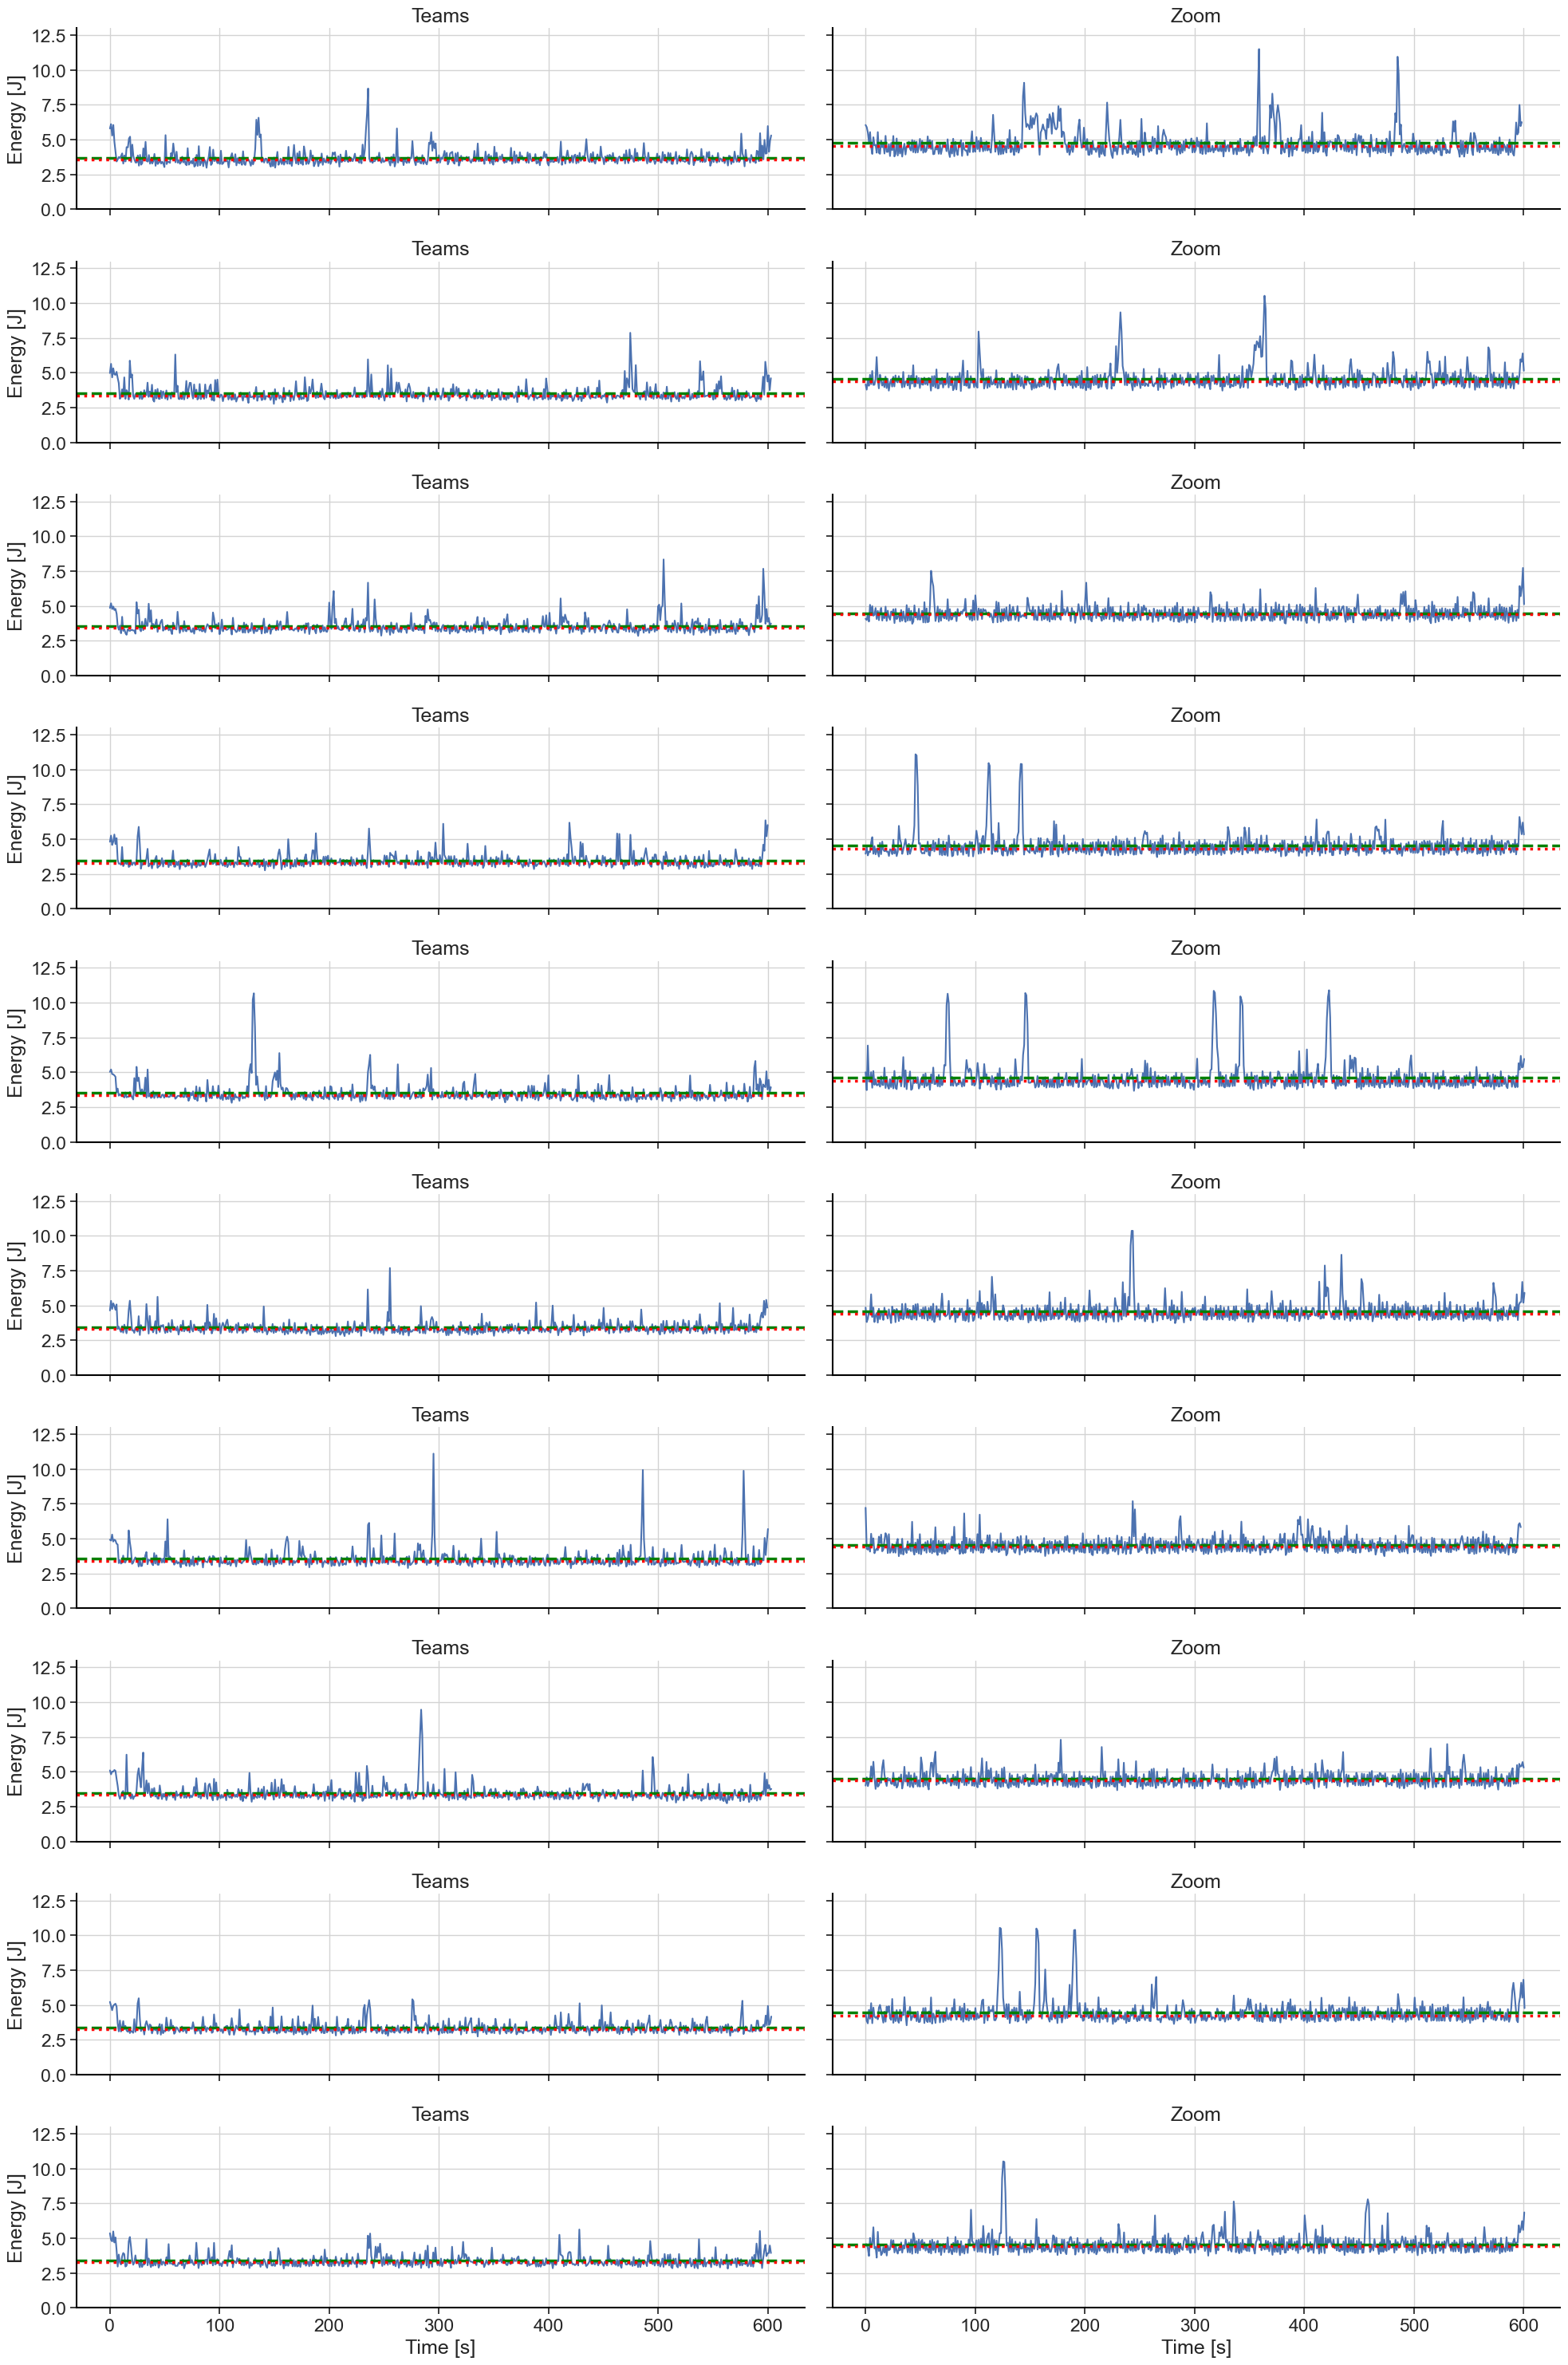

In [27]:
fig, ax = plt.subplots(10, 2, figsize=(20, 30), sharex=True, sharey=True)
for i in range(10):
    sns.lineplot(data=teams_pcm_df[teams_pcm_df['run'] == i], x='Time', y='Proc Energy (Joules)', ax=ax[i, 0])
    ax[i, 0].axhline(y=teams_pcm_df[teams_pcm_df['run'] == i]['Proc Energy (Joules)'].mean(), linewidth=2.5, linestyle='--', color='green')
    ax[i, 0].axhline(y=teams_pcm_df[teams_pcm_df['run'] == i]['Proc Energy (Joules)'].median(), linewidth=2.5, linestyle=':', color='red')
    ax[i, 0].set_ylim(0, 13)
    ax[i, 0].set_yticks(np.arange(0, 13, 2.5))
    ax[i, 0].set_xlabel('Time [s]')
    ax[i, 0].set_ylabel('Energy [J]')
    ax[i, 0].set_title('Teams')
    
    sns.lineplot(data=zoom_pcm_df[zoom_pcm_df['run'] == i], x='Time', y='Proc Energy (Joules)', ax=ax[i, 1])
    ax[i, 1].axhline(y=zoom_pcm_df[zoom_pcm_df['run'] == i]['Proc Energy (Joules)'].mean(), linewidth=2.5, linestyle='--', color='green')
    ax[i, 1].axhline(y=zoom_pcm_df[zoom_pcm_df['run'] == i]['Proc Energy (Joules)'].median(), linewidth=2.5, linestyle=':', color='red')
    ax[i, 1].set_ylim(0, 13)
    ax[i, 1].set_yticks(np.arange(0, 13, 2.5))
    ax[i, 1].set_xlabel('Time [s]')
    ax[i, 1].set_ylabel('Energy [J]')
    ax[i, 1].set_title('Zoom')


# plt.suptitle('Teams vs Zoom by run (Vertical Lines: Mean, Dashed; Median, Dotted)')
fig.tight_layout()
plt.savefig('./figures/individual_runs_energy_over_time.pdf', format='pdf')
plt.show()


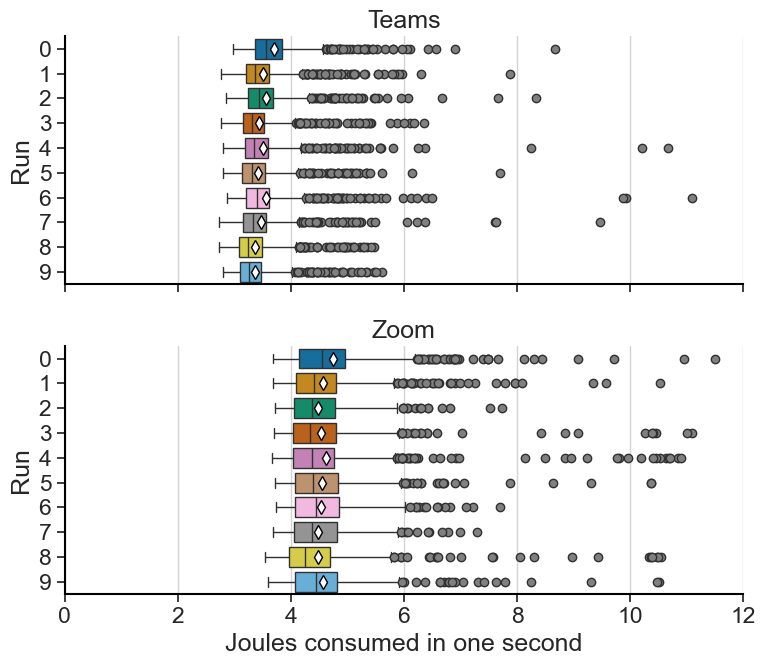

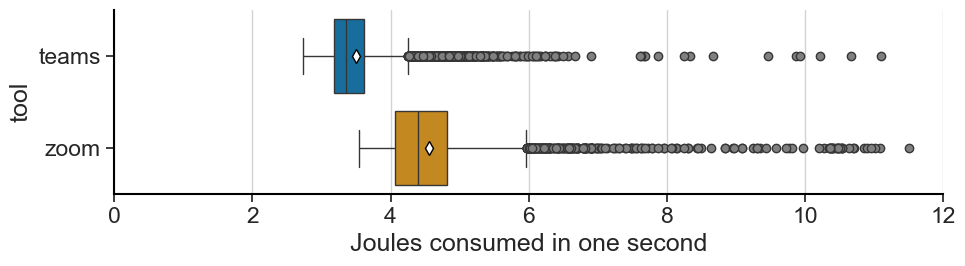

Mean energy consumption for Zoom: 4.558741799831791 J
Mean energy consumption for Teams: 3.49365935354212 J
Teams consumes 23.36% less energy than Zoom


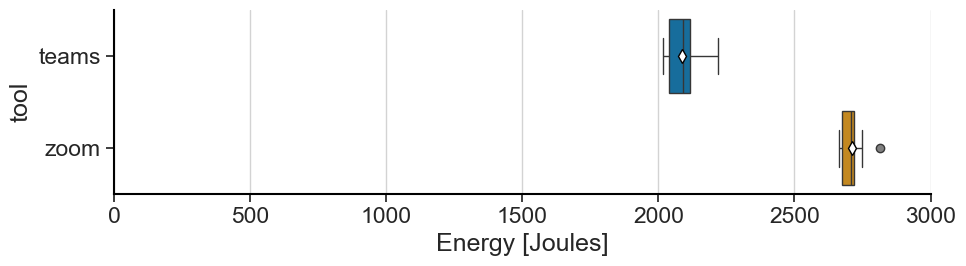

Mean energy consumption for Zoom: 2710.172 J
Mean energy consumption for Teams: 2086.064 J
Teams consumes 23.03% less energy than Zoom


In [35]:
zoom_pcm_df['run'] = zoom_pcm_df['run'].astype('category')
teams_pcm_df['run'] = teams_pcm_df['run'].astype('category')

fig, ax = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
sns.boxplot(data=teams_pcm_df, x='Proc Energy (Joules)', y='run', ax=ax[0], showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, palette='colorblind')
ax[0].set_xlim(0, 12)
ax[0].set_ylabel('Run')
ax[0].set_title('Teams')

sns.boxplot(data=zoom_pcm_df, x='Proc Energy (Joules)', y='run', ax=ax[1], showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, palette='colorblind')
ax[1].set_xlabel('Joules consumed in one second')
ax[1].set_ylabel('Run')
ax[1].set_title('Zoom')

# plt.suptitle('Energy Consumption in Watts by Run')
plt.tight_layout()
plt.savefig('./figures/individual_runs_watts_boxplots.pdf', format='pdf')
plt.show()
    
pcm_df = pd.concat([zoom_pcm_df, teams_pcm_df])
pcm_df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sns.boxplot(data=pcm_df.sort_values(by='tool'), x='Proc Energy (Joules)', y='tool', ax=ax, showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, palette='colorblind')
ax.set_xlim(0, 12)
ax.set_xlabel('Joules consumed in one second')
# plt.title('Energy Consumption in Watts by Tool')
plt.tight_layout()
plt.savefig('./figures/all_runs_watts_boxplots.pdf', format='pdf')
plt.show()

zoom_mean = pcm_df.groupby('tool')['Proc Energy (Joules)'].mean()['zoom']
teams_mean = pcm_df.groupby('tool')['Proc Energy (Joules)'].mean()['teams']
print(f'Mean energy consumption for Zoom: {zoom_mean} J')
print(f'Mean energy consumption for Teams: {teams_mean} J')
print(f'Teams consumes {100 * (zoom_mean - teams_mean) / zoom_mean:.2f}% less energy than Zoom')

grouped_pcm_df = pcm_df.groupby(['tool', 'run'])['Proc Energy (Joules)'].sum().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sns.boxplot(data=grouped_pcm_df, x='Proc Energy (Joules)', y='tool', ax=ax, showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, palette='colorblind')
ax.set_xlim(0, 3000)
ax.set_xlabel('Energy [Joules]')
# plt.title('Total Energy Consumption by Tool')
plt.tight_layout()
plt.savefig('./figures/all_runs_energy_boxplots.pdf', format='pdf')
plt.show()
zoom_mean = grouped_pcm_df.groupby('tool')['Proc Energy (Joules)'].mean()['zoom']
teams_mean = grouped_pcm_df.groupby('tool')['Proc Energy (Joules)'].mean()['teams']
print(f'Mean energy consumption for Zoom: {zoom_mean} J')
print(f'Mean energy consumption for Teams: {teams_mean} J')
print(f'Teams consumes {100 * (zoom_mean - teams_mean) / zoom_mean:.2f}% less energy than Zoom')
